In [1]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from visualization import papermode

papermode(plt, size=18)

In [2]:
abbrs = (*u.abbrange("H", 1, 37), *u.abbrange("H", 39, 74))
# abbrs = (*u.abbrange("H", 1, 15), *u.abbrange("H", 35, 37), *u.abbrange("H", 39, 74))
# abbrs = (*u.abbrange("H", 1, 15), *u.abbrange("H", 35, 37), *u.abbrange("H", 39, 74))

In [3]:
colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}
terrains = sorted(set(u.get_terrain(a) for a in abbrs))
terr_cols = {terr: colors[terr] for terr in terrains}

# Simple labels
splabs = u.COLORS


def add_terrain_legend(mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure], highlighted: Optional[List[str]] = None):
    legend_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in terr_cols.items()]
    if highlighted is not None:
        legend_handles.extend([mpatches.Patch(color="xkcd:bright red", label=lab) for lab in highlighted])
    # mpl_elem.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0), loc="lower left")
    mpl_elem.legend(
        handles=legend_handles, ncol=len(colors), bbox_to_anchor=(0.5, -0.03), loc="upper center", title="Terrain"
    )

In [4]:
p2014_dfs = {}
for abbr in abbrs:
    preprocess(abbr, verbose=False)
    p2014df = pentzer2014pow.pentzer2014pow(abbr, verbose=False);
    p2014_dfs[abbr] = p2014df


H73: 100%|██████████| 466/466 [00:00<00:00, 2827.48it/s]


# Pentzer 2014

In [5]:
model_name = pentzer2014pow.__MODEL_NAME__.title()
figdir = u.get_figdir("summary", subdir=f"multi-model-husky/{model_name}")
model_name = pentzer2014pow.__MODEL_NAME__.title()

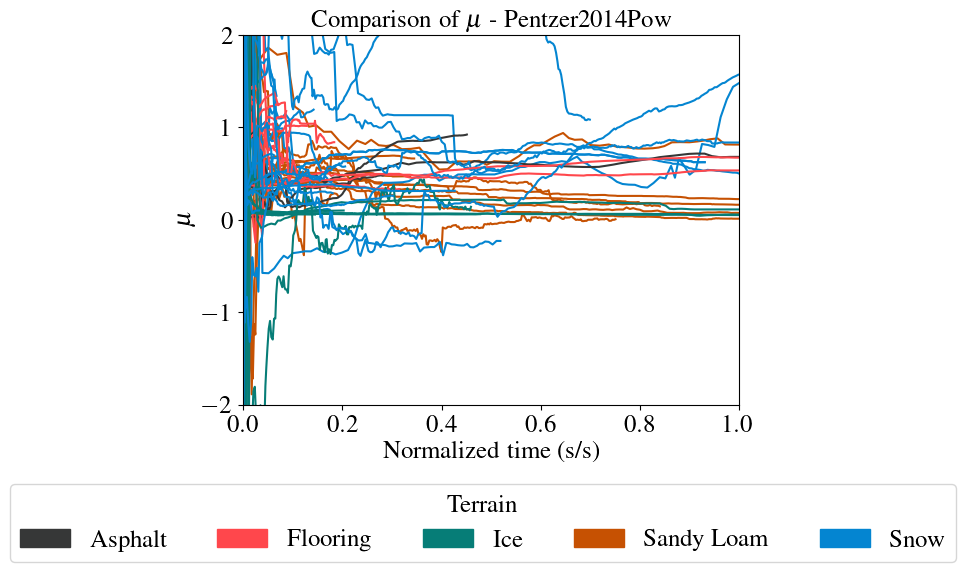

In [6]:
fig, ax = plt.subplots()

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2014_dfs[abbr].time_prop, p2014_dfs[abbr].m_sym, col, label=abbr)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$\mu$")
ax.set_title(f"Comparison of $\mu$ - {model_name}")

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_mu.{ext}", bbox_inches="tight")

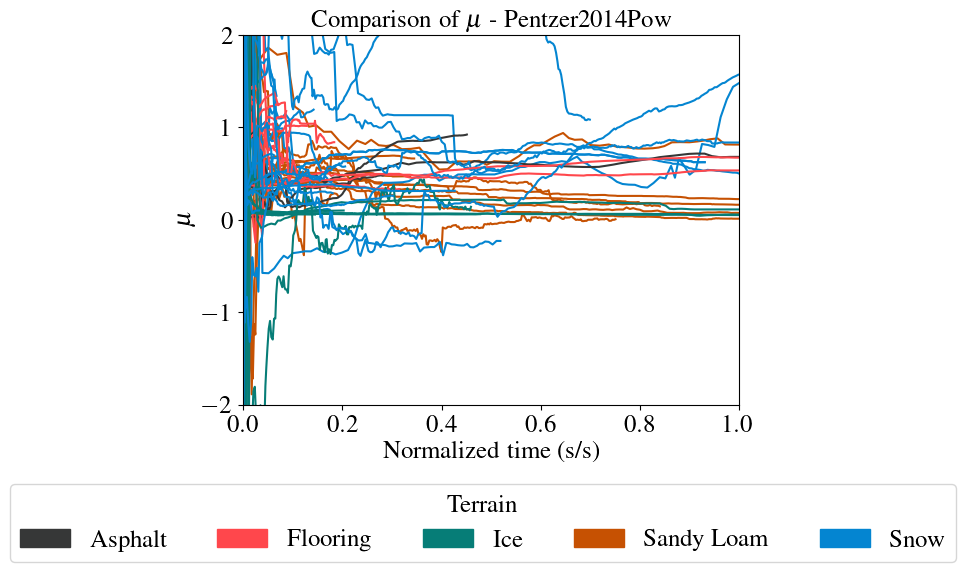

In [7]:
fig, ax = plt.subplots()

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2014_dfs[abbr].time_prop, p2014_dfs[abbr].m_asym, col, label=abbr)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$\mu$")
ax.set_title(f"Comparison of $\mu$ - {model_name}")

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_amu.{ext}", bbox_inches="tight")

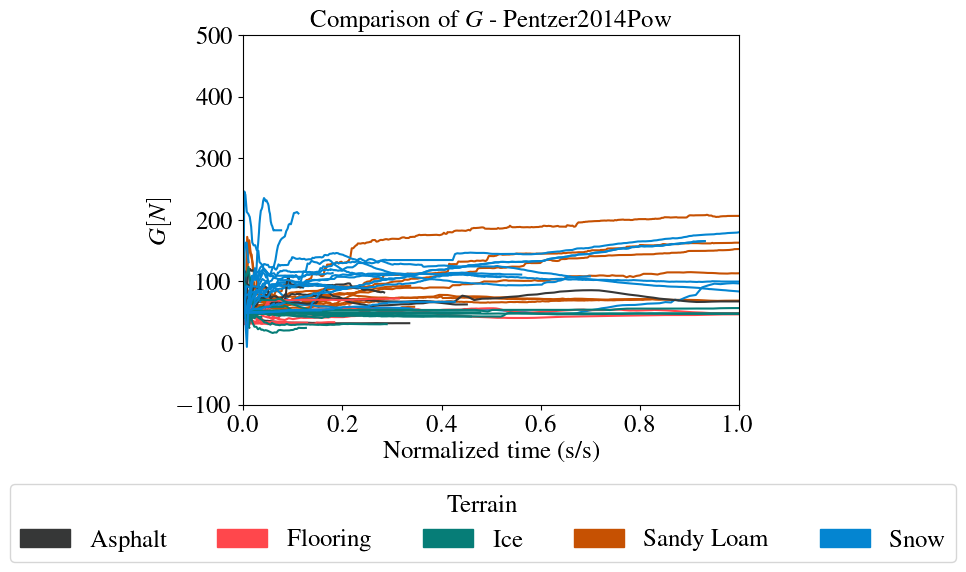

In [8]:
fig, ax = plt.subplots()

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2014_dfs[abbr].time_prop, p2014_dfs[abbr].G_sym, col, label=abbr)
ax.set_ylim(bottom=-100, top=500)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$G [N]$")
ax.set_title(f"Comparison of $G$ - {model_name}")

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_G.{ext}", bbox_inches="tight")

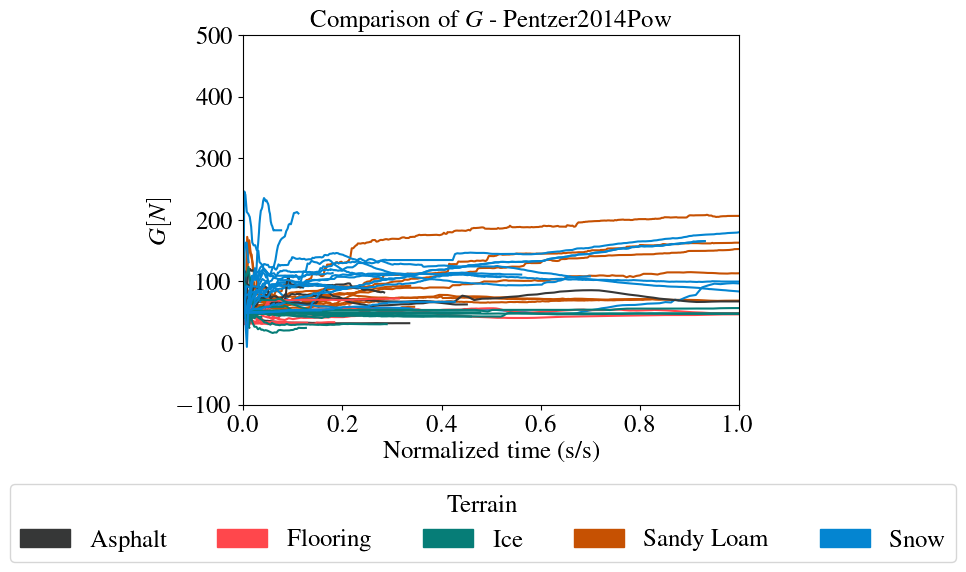

In [9]:
fig, ax = plt.subplots()

for abbr in abbrs:
    col = cols[abbr]
    ax.plot(p2014_dfs[abbr].time_prop, p2014_dfs[abbr].G_asym, col, label=abbr)
ax.set_ylim(bottom=-100, top=500)
ax.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax.set_xlabel("Normalized time (s/s)")
ax.set_ylabel("$G [N]$")
ax.set_title(f"Comparison of $G$ - {model_name}")

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_aG.{ext}", bbox_inches="tight")

# Distribution

In [10]:
abbrs_dict = [{"abbr":a, "terrain":u.get_terrain(a)} for a in abbrs]
mu_df = pd.DataFrame(abbrs_dict)
model_values = u.model_subset_from_json(abbrs, pentzer2014pow.__MODEL_NAME__)
# mu_df["mu"] = mu_df.abbr.apply(lambda x: model_values[x]["coefficients"]["m_sym"]["last"])
mu_df["mu"] = mu_df.abbr.apply(lambda x: p2014_dfs[x].m_sym.dropna().iloc[-int(len(p2014_dfs[x].dropna().index)/6):].to_numpy())

In [11]:
terrains = [
    "asphalt",
    "flooring",
    "ice",
    "sandy loam",
    "snow",
]
y_data = [np.concatenate(mu_df[mu_df.terrain == terr].mu.values) for terr in terrains]

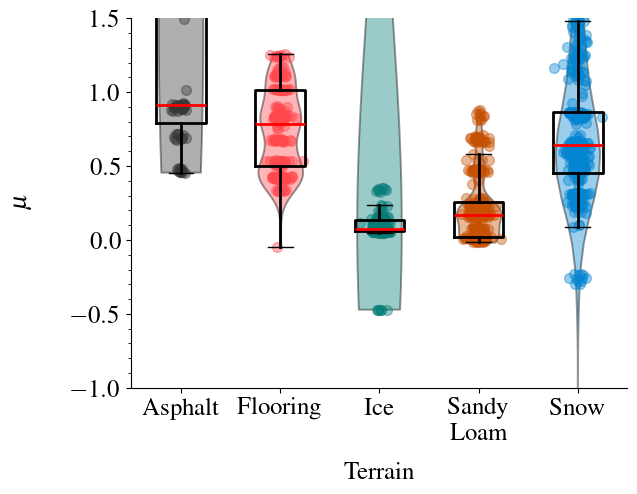

In [12]:
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

x_pos = [*range(len(y_data))]

medianprops = dict(
    linewidth=2,
    color="r",
)
boxprops = dict(linewidth=2, color="k")

fig, ax = plt.subplots()
violins = ax.violinplot(
    y_data,
    positions=x_pos,
    widths=0.45,
    bw_method="silverman",
    showmeans=False,
    showmedians=False,
    showextrema=False,
)

for pc, terr in zip(violins["bodies"], terrains):
    pc.set_facecolor(colors[terr])
    pc.set_edgecolor("k")
    pc.set_linewidth(1.4)
    pc.set_alpha(0.4)

ax.boxplot(
    y_data,
    positions=x_pos,
    showfliers=False,
    showcaps=True,  # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
)

for x, y, terr in zip(x_jittered, y_data, terrains):
    ax.scatter(x, y, s=50, color=colors[terr], alpha=0.4)

xlabels = [terr.title() for terr in terrains]
xlabels[3] = "\n".join(xlabels[3].split(" "))
ax.set_xticks(x_pos)
ax.set_xticklabels(xlabels)

ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.set_ylabel("$\mu$")
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel("Terrain")
ax.xaxis.set_label_coords(0.5, -0.2)

ax.set_ylim(bottom=-1, top=1.5)

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_mbplot.{ext}", bbox_inches="tight")


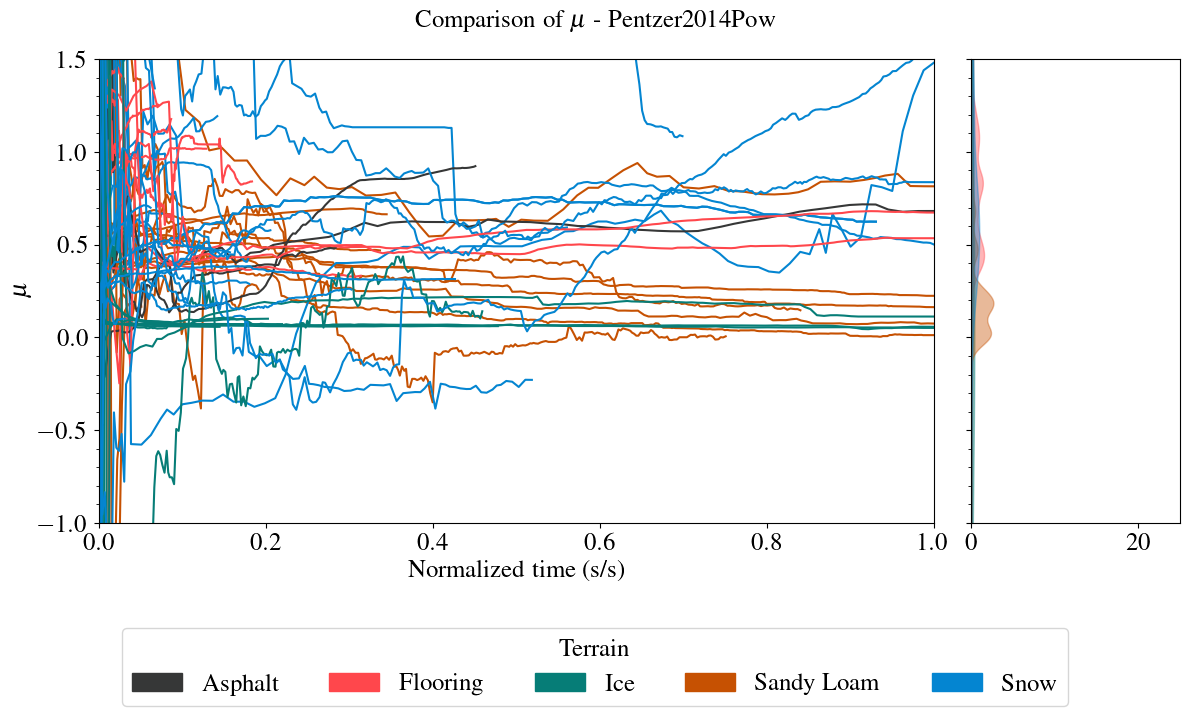

In [13]:
fig, [ax1, ax2] = plt.subplots(figsize=(12,6), ncols=2, gridspec_kw={'width_ratios': [4, 1]}, sharey=True)

for abbr in abbrs:
    col = cols[abbr]
    ax1.plot(p2014_dfs[abbr].time_prop, p2014_dfs[abbr].m_sym, col, label=abbr)
ax1.set_ylim(bottom=-1, top=1.5)
ax1.set_xlim(left=0, right=1)
add_terrain_legend(fig)
ax1.set_xlabel("Normalized time (s/s)")
ax1.set_ylabel("$\mu$")
fig.suptitle(f"Comparison of $\mu$ - {model_name}")

ax2.set_xlim(left=0, right=25)
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
fig.tight_layout()

ys = np.linspace(*ax2.get_ylim(), num=300)

for terr, terr_mu in zip(terrains, y_data):
    terr_col = colors[terr]

    density = st.gaussian_kde(terr_mu)
    density.covariance_factor = lambda: .25
    density._compute_covariance()

    ax2.fill_betweenx(ys, density(ys), color=terr_col, alpha=0.4)

for ext in u.EXTS:
    fig.savefig(figdir / f"{model_name}_mdist.{ext}", bbox_inches="tight")